# Imports, FSL initialization and data preparation

In [48]:
# Various imports

%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ

os.environ["DIPY_HOME"] = "/home/jovyan/Data"

#############################
# Loading fsl and freesurfer within Neurodesk
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths, epi_reg

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

!pip install antspyx
import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm

# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet, flirt, mcflirt
from fsl.wrappers.misc import fslroi

# Nilearn functions for GLM
from nilearn.plotting import plot_design_matrix, plot_stat_map, plot_contrast_matrix
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel
from nilearn.image import mean_img, concat_imgs

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
from mne.datasets import sample
import matplotlib.pyplot as plt

# Scattered import found throughout the labs
from nipype.interfaces.fsl import FAST
import subprocess

In [3]:
# Open FSL eyes

fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()

07:34:36: Debug: Adding duplicate image handler for 'Windows bitmap file'
07:34:36: Debug: Adding duplicate animation handler for '1' type
07:34:36: Debug: Adding duplicate animation handler for '2' type
07:34:36: Debug: Adding duplicate image handler for 'Windows bitmap file'
07:34:36: Debug: Adding duplicate animation handler for '1' type
07:34:36: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:586): Gtk-CRITICAL **: 07:34:36.984: gtk_window_resize: assertion 'height > 0' failed


In [4]:
# Functions to download dataset

def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(url, output_path):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=output_path, reporthook=t.update_to)

def direct_file_download_open_neuro(file_list, file_types, dataset_id, dataset_version, save_dirs):
    # https://openneuro.org/crn/datasets/ds004226/snapshots/1.0.0/files/sub-001:sub-001_scans.tsv
    for i, n in enumerate(file_list):
        subject = n.split('_')[0]
        download_link = 'https://openneuro.org/crn/datasets/{}/snapshots/{}/files/{}:{}:{}'.format(dataset_id, dataset_version, subject, file_types[i],n)
        print('Attempting download from ', download_link)
        download_url(download_link, op.join(save_dirs[i], n))
        print('Ok')

In [8]:
# Download dataset

dataset_fmap = 'ds000171'
subject_fmap = '001'

# Main directory
bids_root = op.join(op.dirname(sample.data_path()), dataset_fmap)

# Paths for functional and anatomical data
func_path = op.join(bids_root, 'sub-control01', 'func')
anat_path = op.join(bids_root, 'sub-control01', 'anat')
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

# Create directories for func and anat
mkdir_no_exist(bids_root)
mkdir_no_exist(op.join(bids_root, 'sub-control01'))
mkdir_no_exist(func_path)
mkdir_no_exist(anat_path)
mkdir_no_exist(deriv_root)
mkdir_no_exist(preproc_root)

# List of functional files to download
file_list = [
    'sub-control01_task-music_run-1_bold.nii.gz',
    'sub-control01_task-music_run-1_events.tsv',
    'sub-control01_task-music_run-2_bold.nii.gz',
    'sub-control01_task-music_run-2_events.tsv',
    'sub-control01_task-music_run-3_bold.nii.gz',
    'sub-control01_task-music_run-3_events.tsv',
]

file_types = ['func'] * len(file_list)
save_dirs = [func_path] * len(file_list)


direct_file_download_open_neuro(file_list=file_list, 
                                 file_types=file_types, 
                                 dataset_id=dataset_fmap, 
                                 dataset_version='00001', 
                                 save_dirs=save_dirs)

# List of anatomical files to download
anat_file_list = ['sub-control01_T1w.nii.gz']

# For the anac files, define their types and save directories
anat_file_types = ['anat'] * len(anat_file_list)
anat_save_dirs = [anat_path] * len(anat_file_list)

# Download anatomical files
direct_file_download_open_neuro(file_list=anat_file_list, 
                                 file_types=anat_file_types, 
                                 dataset_id=dataset_fmap, 
                                 dataset_version='00001', 
                                 save_dirs=anat_save_dirs)

otherfiles_list = [
    'CHANGES',
    'README',
    'dataset_description.json',
    'T1w.json',
    'participants.tsv',
    'task-music_bold.json',
    'task-nonmusic_bold.json'
]

for filename in otherfiles_list:
    # Construct the download link for these files
    download_link = f'https://openneuro.org/crn/datasets/{dataset_fmap}/snapshots/00001/files/{filename}'
    print(f'Attempting download from: {download_link}')
    # Download the file without specifying file_type
    download_url(download_link, op.join(bids_root, filename))
    print('Downloaded:', filename)

Using default location ~/mne_data for sample...
Creating /home/jovyan/mne_data


100%|█████████████████████████████████████| 1.65G/1.65G [00:00<00:00, 2.37TB/s]
Untarring contents of '/home/jovyan/mne_data/MNE-sample-data-processed.tar.gz' to '/home/jovyan/mne_data'


Attempting to create new mne-python configuration file:
/home/jovyan/.mne/mne-python.json
Download complete in 01m54s (1576.2 MB)
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-1_bold.nii.gz


sub-control01:func:sub-control01_task-music_run-1_bold.nii.gz: 35.5MB [00:14, 2.37MB/s]                  


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-1_events.tsv


sub-control01:func:sub-control01_task-music_run-1_events.tsv: 8.19kB [00:00, 24.5kB/s]


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-2_bold.nii.gz


sub-control01:func:sub-control01_task-music_run-2_bold.nii.gz: 35.5MB [00:15, 2.31MB/s]                  


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-2_events.tsv


sub-control01:func:sub-control01_task-music_run-2_events.tsv: 8.19kB [00:00, 11.4kB/s]


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-3_bold.nii.gz


sub-control01:func:sub-control01_task-music_run-3_bold.nii.gz: 35.5MB [00:02, 13.5MB/s]                


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:func:sub-control01_task-music_run-3_events.tsv


sub-control01:func:sub-control01_task-music_run-3_events.tsv: 8.19kB [00:00, 11.7kB/s]


Ok
Attempting download from  https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/sub-control01:anat:sub-control01_T1w.nii.gz


sub-control01:anat:sub-control01_T1w.nii.gz: 9.21MB [00:01, 5.83MB/s]                


Ok
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/CHANGES


CHANGES: 8.19kB [00:00, 16.0kB/s]


Downloaded: CHANGES
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/README


README: 8.19kB [00:00, 15.3kB/s]


Downloaded: README
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/dataset_description.json


dataset_description.json: 8.19kB [00:00, 13.8kB/s]


Downloaded: dataset_description.json
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/T1w.json


T1w.json: 8.19kB [00:00, 15.0kB/s]


Downloaded: T1w.json
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/participants.tsv


participants.tsv: 8.19kB [00:00, 14.9kB/s]


Downloaded: participants.tsv
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/task-music_bold.json


task-music_bold.json: 8.19kB [00:00, 14.2kB/s]


Downloaded: task-music_bold.json
Attempting download from: https://openneuro.org/crn/datasets/ds000171/snapshots/00001/files/task-nonmusic_bold.json


task-nonmusic_bold.json: 8.19kB [00:00, 15.2kB/s]

Downloaded: task-nonmusic_bold.json


In [9]:
# Data standardization

# Load the individual fMRI runs
run1 = nib.load(op.join(func_path, 'sub-control01_task-music_run-1_bold.nii.gz'))
run2 = nib.load(op.join(func_path, 'sub-control01_task-music_run-2_bold.nii.gz'))
run3 = nib.load(op.join(func_path, 'sub-control01_task-music_run-3_bold.nii.gz'))

concatenated_file_path = '/home/jovyan/mne_data/ds000171/sub-control01/func/sub-control01_task-music_concatenated_bold.nii.gz'

def standardize_img(img):
    data = img.get_fdata()
    mean = np.mean(data)
    std = np.std(data)
    standardized_data = (data - mean) / std
    return nib.Nifti1Image(standardized_data, img.affine)

run1_standardized = standardize_img(run1)
run2_standardized = standardize_img(run2)
run3_standardized = standardize_img(run3)

concatenated_img = concat_imgs([run1_standardized, run2_standardized, run3_standardized])

nib.save(concatenated_img, concatenated_file_path)

print("Concatenation complete and saved as 'sub-control01_task-music_concatenated_bold.nii.gz'.")

Concatenation complete and saved as 'sub-control01_task-music_concatenated_bold.nii.gz'.


In [6]:
# Display standardized data

fsleyesDisplay.resetOverlays()

if op.exists(concatenated_file_path):
    fsleyesDisplay.load(concatenated_file_path)
    
    print("Loaded:", concatenated_file_path)
else:
    print("File does not exist at the specified path.")


(ipykernel_launcher.py:512): Gdk-WARNING **: 17:27:35.796: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:27:35: Debug: ClientToScreen cannot work when toplevel window is not shown
17:27:35: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:512): Gdk-WARNING **: 17:27:35.799: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:27:35: Debug: ClientToScreen cannot work when toplevel window is not shown
17:27:35: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:512): Gdk-WARNING **: 17:27:35.801: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:27:35: Debug: ClientToScreen cannot work when toplevel window is not shown
17:27:35: Debug: ClientToScreen cannot work when toplevel window is not shown

(ipykernel_launcher.py:512): Gdk-WARNING **: 17:27:35.802: gdkdrawable-x11.c:952 drawable is not a pixmap or window
17:27:35: Debug: ClientToScreen cannot work when toplevel window

Loaded: /home/jovyan/mne_data/ds000171/sub-control01/func/concatenated_task_music_bold.nii.gz


# Preprocessing

## Anatomical

### Skull stripping

In [10]:
# BET

def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Perform skull-stripping on the T1w anatomical image for the specified subject.
        Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    subject = f'sub-{subject_id}'
    anatomical_path = op.join(bids_root, subject, 'anat', f'{subject}_T1w.nii.gz')
    
    betted_brain_path = op.join(preproc_root, subject, 'anat', f'{subject}_T1w')

    mkdir_no_exist(op.join(preproc_root, subject, 'anat'))
    
    os.system(f'bet {anatomical_path} {betted_brain_path} -m {"-R" if robust else ""}')
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w_mask')

get_skull_stripped_anatomical(bids_root, preproc_root, "control01", robust=True)


Done with BET.


In [11]:
# Display BET

fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(concatenated_file_path)
fsleyesDisplay.load(resulting_mask_path)


(ipykernel_launcher.py:586): Gdk-WARNING **: 07:44:20.756: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [12]:
# Actually extract the brain

def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    """
    Parameters
    ----------
    img_path: str
        Path to the input image that needs to be masked.
    mask_path: str
        Path to the mask image.
    masked_img_path: str
        Path where the masked output image will be saved.
    """
    # Execute the fslmaths command with the -mas option
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    print(f"Masked image saved at: {masked_img_path}")

# Define paths based on your dataset structure
subject_id = "control01"
anatomical_path = op.join(bids_root, f'sub-{subject_id}', 'anat', f'sub-{subject_id}_T1w.nii.gz')  # Original brain
betted_brain_path = op.join(preproc_root, f'sub-{subject_id}', 'anat', f'sub-{subject_id}_T1w.nii.gz')  # Skull-stripped brain
resulting_mask_path = op.join(preproc_root, f'sub-{subject_id}', 'anat', f'sub-{subject_id}_T1w_mask.nii.gz')  # The mask

apply_fsl_math_approach(betted_brain_path, resulting_mask_path, anatomical_path)


Masked image saved at: /home/jovyan/mne_data/ds000171/sub-control01/anat/sub-control01_T1w.nii.gz


In [13]:
# Display the extracted brain

fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(betted_brain_path)

### Segmentation

In [14]:
# FAST segmentation

subject = f'sub-{subject_id}'
anatomical_path = op.join(bids_root, subject, 'anat', f'{subject}_T1w.nii.gz')
bet_path = op.join(preproc_root, subject, 'anat', f'{subject}_T1w')

fast_target = bet_path # Replace with either anatomical_path or bet_path (note: you can try both and decide which is more reasonable!)

[os.remove(f) for f in glob.glob(op.join(preproc_root, subject, 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell
segmentation_path = op.join(preproc_root, subject, 'anat', f'{subject}_T1w_fast')
fast(imgs=[fast_target], out=segmentation_path, n_classes=3)
print("FAST segmentation complete.")

FAST segmentation complete.


# Functional

Text(0, 0.5, 'Mean voxel intensity')

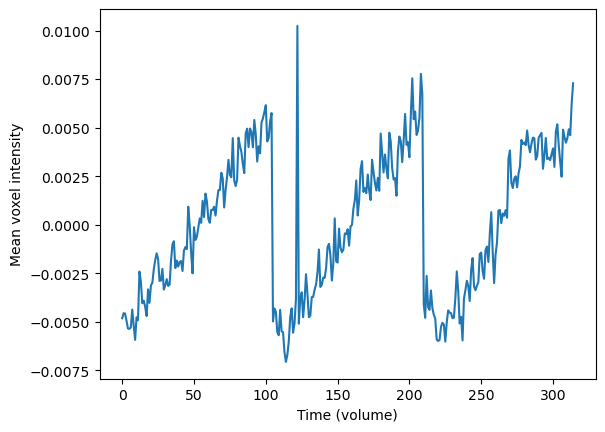

In [18]:
# Check the contrast
# looking at the y-axis I guess we are fine (?)
# I checked there are 315 volumes

plt.plot(nib.load(op.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold.nii.gz')).get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

### Motion correction

In [19]:
# Motion Correction

dataset_id = 'ds000171'
subject = '01' 

mkdir_no_exist(os.path.join(preproc_root, 'sub-control01', 'func'))

path_original_data = os.path.join(bids_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold.nii.gz')
path_moco_data = os.path.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco.nii.gz')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concatenated_bold_moco.nii.gz

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [157] to 8 mm pixels
Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][

refnum = 157
Original_refvol = -1


Registering volumes ... [158][159][160][161][162][163][164][165][166][167][168][169][170][171][172][173][174][175][176][177][178][179][180][181][182][183][184][185][186][187][188][189][190][191][192][193][194][195][196][197][198][199][200][201][202][203][204][205][206][207][208][209][210][211][212][213][214][215][216][217][218][219][220][221][222][223][224][225][226][227][228][229][230][231][232][233][234][235][236][237][238][239][240][241][242][243][244][245][246][247][248][249][250][251][252][253][254][255][256][257][258][259][260][261][262][263][264][265][266][267][268][269][270][271][272][273][274][275][276][277][278][279][280][281][282][283][284][285][286][287][288][289][290][291][292][293][294][295][296][297][298][299][300][301][302][303][304][305][306][307][308][309][310][311][312][313][314][156][155][154][153][152][151][150][149][148][147][146][145][144][143][142][141][140][139][138][137][136][135][134][133][132][131][130][129][128][127][126][125][124][123][122][121][120][119][

{}

In [20]:
# Show motion correction

fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(path_moco_data)

In [21]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- participants.tsv
|--- task-music_bold.json
|--- task-nonmusic_bold.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|------------ func/
|--------------- sub-control01_task-music_concatenated_bold_moco.nii.gz
|--------------- sub-control01_task-music_concatenated_bold_moco.nii.gz.par
|--------------- sub-control01_task-music_concatenated_bold_moco.nii.gz.mat/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- su

In [23]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco.nii.gz.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.003267,0.002930,5.552720e-07,-0.059817,-0.518985,-0.470659
1,-0.003333,0.002930,-1.600820e-04,-0.066681,-0.490942,-0.467984
2,-0.003147,0.002880,-1.880300e-04,-0.053630,-0.470922,-0.446214
3,-0.003264,0.003291,-3.337180e-04,-0.067658,-0.483699,-0.463707
4,-0.002729,0.003120,-3.183150e-04,-0.073350,-0.470581,-0.494909
...,...,...,...,...,...,...
310,0.008946,-0.000008,-2.131270e-03,-0.087116,0.400872,0.237711
311,0.009100,-0.000159,-2.114960e-03,-0.084539,0.374362,0.217879
312,0.009154,-0.000425,-1.901570e-03,-0.085075,0.404540,0.224777
313,0.008975,-0.000425,-2.162820e-03,-0.103438,0.370850,0.211481


In [24]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

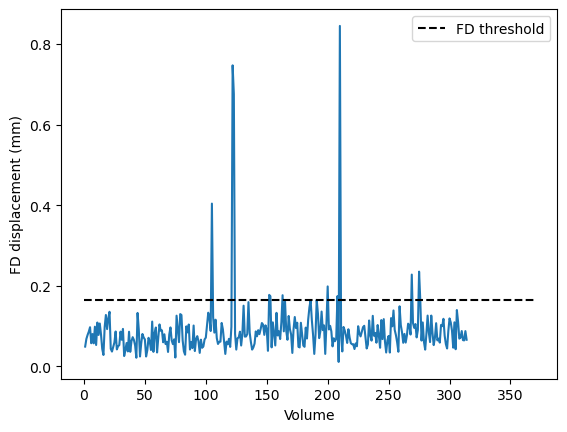

In [25]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 370,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

### Coregistration

In [27]:
# Coregistration with epi_reg

epi_target = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco')
whole_t1 = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w')
skull_stripped_t1 = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w')
output_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_bbr')
ref_vol_name =  op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco_vol_middle')

use_single_vol = True

if use_single_vol:
    # Extract the middle volume with fslroi as we've seen before :)
    fslroi(epi_target, ref_vol_name, str(182), str(1))
    # Call epi_reg
    subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(output_path)])
else:
    subprocess.run(['epi_reg','--epi={}'.format(epi_target), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(output_path)])

Running FAST segmentation
FLIRT pre-alignment
Running BBR
0.302893 0.999475 -0.032397 0.000570 0.000000 0.032393 0.999457 0.006027 0.000000 -0.000765 -0.006005 0.999982 0.000000 -4.108243 7.995462 -1.185797 1.000000 


In [28]:
# Clean up needed after epi_reg

def cleanup_epi_reg(path_to_clean):
    patterns = ['*_fast_*', '*_fieldmap*']
    for p in patterns:
        files = glob.glob(op.join(path_to_clean, p))
        for f in files:
            os.remove(f)
cleanup_epi_reg(op.join(preproc_root, 'sub-001', 'func'))

In [29]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- participants.tsv
|--- task-music_bold.json
|--- task-nonmusic_bold.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|------------ func/
|--------------- sub-control01_task-music_concatenated_bold_bbr.mat
|--------------- sub-control01_task-music_concatenated_bold_bbr.nii.gz
|--------------- sub-control01_task-music_concatenated_bold_bbr_fast_wmedge.nii.gz
|--------------- sub-control01_task-music_concatenated_bold_bbr_fast_wmseg.nii.gz
|--------------- s

### Smoothing

In [31]:
# Smoothing

output_path = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco.nii.gz')

cmd = 'fslmaths {} -s {} {}_smoothed-6mm'.format(output_path, 6/2.3548, output_path)
subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), '{}_smoothed-6mm'.format(output_path)])



CompletedProcess(args=['fslmaths', '/home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concatenated_bold_moco.nii.gz', '-s', '2.547987090198743', '/home/jovyan/mne_data/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_concatenated_bold_moco.nii.gz_smoothed-6mm'], returncode=0)

In [32]:
# See smoothing

fsleyesDisplay.load(output_path + '_smoothed-6mm')

# GLM

In [33]:
func_path = op.join(bids_root, 'sub-control01', 'func')

evt1=pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-1_events.tsv'), sep='\t')
evt2=pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-2_events.tsv'), sep='\t')
evt3=pd.read_csv(op.join(func_path, 'sub-control01_task-music_run-3_events.tsv'), sep='\t')

evt_concat=pd.concat([evt1,evt2,evt3], ignore_index=True)
evt_concat['onset']=evt_concat['duration'].cumsum()
evt_concat

,onset,duration,trial_type
0,33.0,33.0,tones
1,36.0,3.0,response
2,67.5,31.5,negative_music
3,70.5,3.0,response
4,102.0,31.5,tones
5,105.0,3.0,response
6,136.5,31.5,positive_music
7,139.5,3.0,response
8,171.0,31.5,tones
9,174.0,3.0,response


In [34]:
TR = 3  # Repetition time (in seconds)
total_time = 936  # Total time of the scan in seconds
time_points = np.arange(0, total_time, TR)

In [38]:
# Generate design matrix using Nilearn's HRF

design_matrix = make_first_level_design_matrix(
    frame_times=time_points,
    events=evt_concat,
    hrf_model='spm',
    drift_model='polynomial'
)

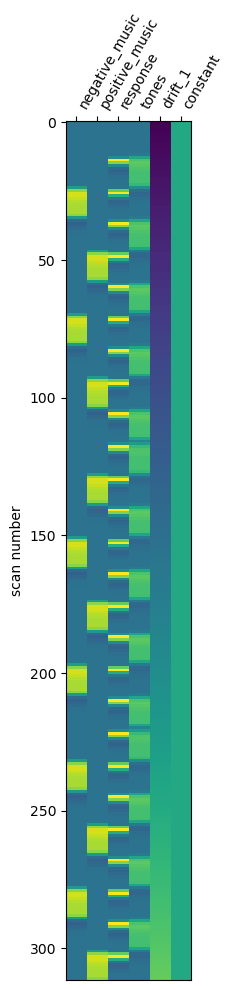

In [39]:
plot_design_matrix(design_matrix)
plt.show()

In [40]:
fmri_img = op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_concatenated_bold_moco.nii.gz_smoothed-6mm.nii.gz')

In [44]:
# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)

fmri_glm = FirstLevelModel(t_r=3,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
fmri_glm = fmri_glm.fit(fmri_img, evt_concat)

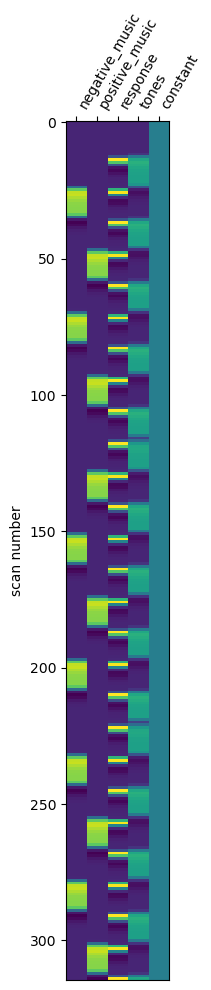

In [45]:
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

In [54]:
conditions = {
    'active_neg': np.array([1, 0, 0,0,0]), 
    'active_pos':np.array([0, 1,0, 0,0]), 
    'response':np.array([0, 0,1, 0,0]), 
    'neutral':np.array([0, 0, 0,1,0]) 

}

contrasts = {
    'pos_vs_neg' : conditions['active_pos'] - conditions['active_neg'],
    'pos_vs_neu' : conditions['active_pos'] - conditions['neutral'],
    'neg_vs_neu' : conditions['active_neg'] - conditions['neutral']
}


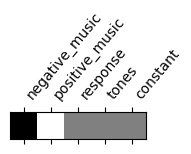

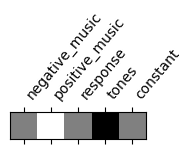

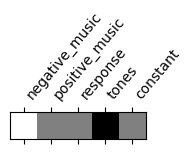

In [55]:
for contrast, weights in contrasts.items():
    plot_contrast_matrix(weights, design_matrix=fmri_glm.design_matrices_[0])  ####TODO ADD COLOR SCALE

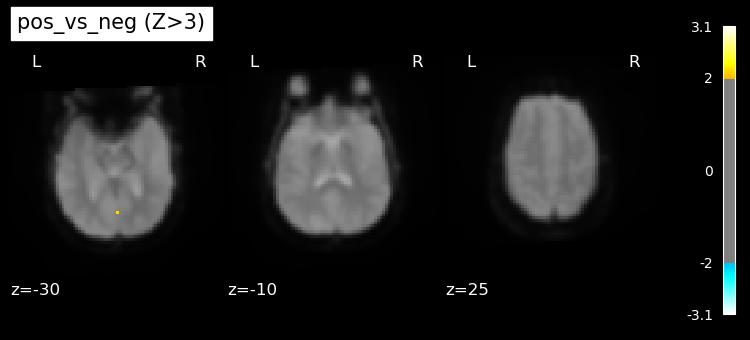

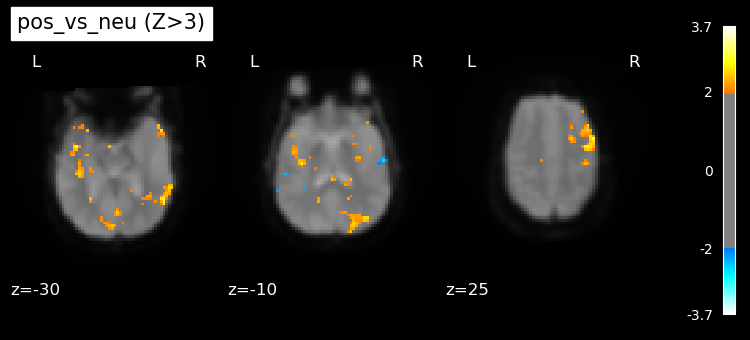

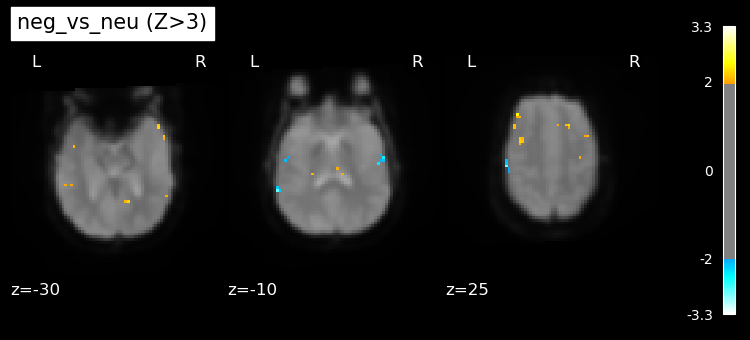

In [56]:
for contrast, weights in contrasts.items():
    z_map = fmri_glm.compute_contrast(weights,
                                      output_type='z_score')
    
    nib.save(z_map, 'z_map_uncorrected_' + str(contrast) + '.nii.gz')
    mean_img_ = mean_img(fmri_img),
    plot_stat_map(z_map, bg_img=mean_img_[0], threshold=2.0,
                  display_mode='z', cut_coords=[-30,-10,25], black_bg=True,
                  title=str(contrast)+' (Z>3)')
    plt.show()